# Sentiment Analysis Capres–Cawapres: ML with Regression and Naive Bayes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Notebook ini menyajikan pipeline **lengkap** untuk analisis sentimen teks (Bahasa Indonesia) dari dataset Twitter.
Kita akan melalui tahapan **Deep Learning Lifecycle**:
1) **Problem framing** & setup  
2) **Data loading & EDA ringan**  
3) **Data cleaning & label normalization**  
4) **Feature engineering** (tokenisasi, padding)
5) **Step: Classical Machine Learning Model Comparison**  (aris mulai dari sini)
  


## 0. Setup

In [2]:
# Komentar: Import library dan set seed agar hasil reprodusibel
import os, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Optional: cek versi TensorFlow (wajib untuk train)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 1. Load Data & EDA ringkas

In [3]:
# Komentar: Baca CSV, deteksi kolom teks & label, lihat distribusi kelas
DATA_PATH = "/content/drive/MyDrive/Proyek/Data/tweet.csv"
df = pd.read_csv(DATA_PATH, encoding="utf-8", on_bad_lines="skip", low_memory=False)
text_col = 'tweet' if 'tweet' in df.columns else df.select_dtypes(include='object').columns[0]
label_col = 'sentimen' if 'sentimen' in df.columns else None
display(df.head())
print("Kolom teks:", text_col, "| Kolom label:", label_col)
if label_col:
    print(df[label_col].value_counts())

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


Kolom teks: tweet | Kolom label: sentimen
sentimen
positif    612
netral     607
negatif    596
Name: count, dtype: int64


## 2. Data Cleaning & Label Normalization

In [4]:
# Komentar: Bersihkan URL/mention/emoji, lowercasing; normalisasi label ke 3 kelas
import re
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
EMOJI_RE = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
MENTION_RE = re.compile(r"@\w+")

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.strip()
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = s.replace("#", " ")
    s = EMOJI_RE.sub(" ", s)
    s = re.sub(r"[^0-9a-zA-ZÀ-ÿ\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def normalize_label(x):
    if not isinstance(x, str): return "neutral"
    xl = x.strip().lower()
    mapping = {
        "pos":"positive","positif":"positive","positive":"positive",
        "neg":"negative","negatif":"negative","negative":"negative",
        "neu":"neutral","netral":"neutral","neutral":"neutral"
    }
    return mapping.get(xl, xl if xl in {"positive","negative","neutral"} else "neutral")

df = df.copy()
df["text"] = df[text_col].astype(str).map(clean_text)
df["label"] = df[label_col].astype(str).map(normalize_label)
df[["text","label"]].head()

,text,label
0,kata indonesia tidak dihargai bangsa asing ber...,negative
1,batuan langka tasbih jokowi hadiah dari habib ...,neutral
2,di era jokowi ekonomi indonesia semakin baik 0...,neutral
3,bagi sumatera selatan asian games berdampak pd...,positive
4,negara kita ngutang buat bngun infrastruktur y...,negative


In [5]:
df["label"].value_counts()

,count
label,
positive,612
neutral,607
negative,596


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords

In [7]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_id = list(set(stopwords.words('indonesian')))

## 3. Split Data (Train/Val/Test)

In [8]:
# Komentar: Stratified split 70/15/15
from sklearn.model_selection import train_test_split
label_to_id = {"negative":0, "neutral":1, "positive":2}
id_to_label = {v:k for k,v in label_to_id.items()}

X = df["text"].values
y = np.array([label_to_id.get(v,1) for v in df["label"].values], dtype=np.int32)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(len(X_train), len(X_val), len(X_test))

1270 272 273


In [12]:
vectorizer = CountVectorizer(stop_words=stopword_id)
X_train_vector=vectorizer.fit_transform(X_train)
X_train_vector.shape

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


(1270, 5571)

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopword_id = list(set(stopwords.words('indonesian')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=stopword_id)
X_train_vector=vectorizer.fit_transform(X_train)
X_train_vector.shape

(1270, 5571)

In [14]:
X_train_array = X_train_vector.toarray()
df = pd.DataFrame(data=X_train_array, columns = vectorizer.get_feature_names_out()) # untuk scikit learn baru, menggunakan get_feature_names()
df

,000,01,01indonesiamaju,01jokowiamin,01ndonesiamaju,01optimisindonesiamaju,02,02menangdebat,02menangradikalorbaasengberkuasa,02tunggangiislam,...,ziarah,zippo,zk7rklfe13,zon,zonk,zp5i6idv9d,zpno3e1eo2,zswykszpbu,ztf4kwjtgj,zy2ggj93fp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X_test_vector=vectorizer.transform(X_test)
X_test_vector.shape

(273, 5571)

In [16]:
X_val_vector=vectorizer.transform(X_val)
X_val_vector.shape

(272, 5571)

## 4. Feature Engineering (Tokenizer, Sequences, Padding)

In [17]:
# Komentar: Tokenizer Keras + padding; simpan tokenizer untuk deployment
MAX_VOCAB = 30000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(list(X_train))

import numpy as np
lengths = np.array([len(t.split()) for t in X_train])
maxlen = int(min(80, np.percentile(lengths, 95)))
if maxlen < 20: maxlen = 20

def seq_pad(texts):
    seq = tokenizer.texts_to_sequences(list(texts))
    return pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post")

X_train_ids = seq_pad(X_train)
X_val_ids = seq_pad(X_val)
X_test_ids = seq_pad(X_test)

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
vocab_size, maxlen

(6059, 43)

## 5: Classical Machine Learning Model Comparison (Aris mulai dari sini)

Training Naive Bayes...

Naive Bayes Accuracy: 0.6154
              precision    recall  f1-score   support

           0       0.62      0.68      0.65        90
           1       0.68      0.57      0.62        91
           2       0.56      0.60      0.58        92

    accuracy                           0.62       273
   macro avg       0.62      0.62      0.62       273
weighted avg       0.62      0.62      0.62       273



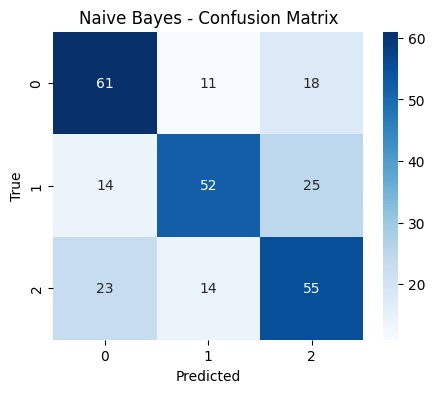

Training Logistic Regression...

Logistic Regression Accuracy: 0.6044
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        90
           1       0.63      0.57      0.60        91
           2       0.59      0.50      0.54        92

    accuracy                           0.60       273
   macro avg       0.60      0.61      0.60       273
weighted avg       0.60      0.60      0.60       273



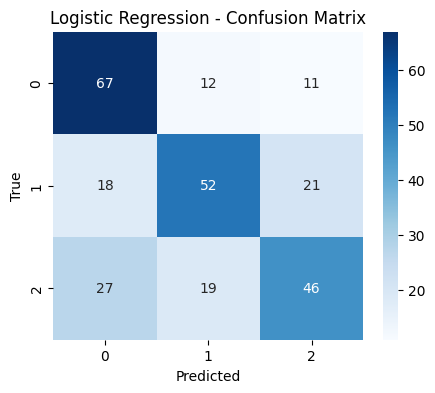


=== Model Comparison (Baseline) ===
Naive Bayes: 0.6154
Logistic Regression: 0.6044


In [18]:
# ============================================================
# Step 7: Baseline Classical ML Models (Naive Bayes & Logistic Regression)
# ============================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use TF-IDF instead of padded sequences (works better for classical models)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

# Define models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    print("="*60)
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Save results
    results[name] = acc

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Compare performance summary
print("\n=== Model Comparison (Baseline) ===")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")
